## Importing json file and preproccessing data

In [95]:
import numpy as np
import pandas as pd
import json

# Opening and loading jaccard distance tri-tone file
file = open('clean_tri_tone_synthetic.json')
#imported as a dict
data = json.load(file)
file.close()

# converting dict to pd.DataFrame 
df2 = pd.DataFrame.from_dict(data, orient='index')
# only pulling out tone because thats our label
tones = pd.DataFrame(df2.tone)
##########################
#print(df2) # to see issue
##########################

# convert vectory array to list so that each vector has its own column
jaccard_df = pd.DataFrame(df2.vec.tolist())

# Our feature
jaccard_df
# # merging tones and new dataframe together
# jaccard_df = pd.DataFrame(np.hstack([dataframe, tones])) # use np.hstack instead of pd.concat becuase of error issues
# #rename last column to Tone
# jaccard_df.rename(columns={jaccard_df.columns[332]: "Tone"}, inplace=True)
# jaccard_df


,0,1,2,3,4,5,6,7,8,9,...,322,323,324,325,326,327,328,329,330,331
0,0.023095,0.027842,0.042857,0.042553,0.037281,0.045673,0.043796,0.043578,0.044150,0.048387,...,0.039301,0.033408,0.046980,0.034169,0.038462,0.049774,0.043764,0.042316,0.037118,0.053613
1,0.039535,0.037123,0.037559,0.030093,0.032468,0.052758,0.028504,0.036117,0.043764,0.040816,...,0.025641,0.028571,0.030568,0.043280,0.045564,0.033113,0.047930,0.032823,0.041304,0.041096
2,0.057604,0.043182,0.048499,0.052995,0.040426,0.046404,0.052009,0.044346,0.044872,0.068027,...,0.035789,0.050328,0.052174,0.037528,0.027523,0.052632,0.057940,0.043103,0.044681,0.044643
3,0.051522,0.049065,0.034965,0.037123,0.050439,0.045024,0.043165,0.031320,0.039046,0.042986,...,0.047826,0.042129,0.037199,0.045455,0.045346,0.035242,0.047722,0.037199,0.045652,0.062645
4,0.046729,0.046729,0.037471,0.030023,0.039130,0.050119,0.043269,0.036036,0.050549,0.038375,...,0.038877,0.033040,0.048780,0.057604,0.042959,0.056306,0.041037,0.044150,0.041215,0.050575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.035377,0.030516,0.035800,0.035545,0.049217,0.038554,0.031553,0.039171,0.037611,0.039171,...,0.041943,0.036036,0.040359,0.032110,0.031325,0.033708,0.046460,0.035714,0.039735,0.020501
1496,0.032333,0.046838,0.037559,0.047059,0.050661,0.050239,0.033413,0.033784,0.046053,0.038462,...,0.050328,0.044643,0.041943,0.031532,0.045564,0.049327,0.041126,0.037363,0.036797,0.053118
1497,0.039813,0.039813,0.052758,0.040000,0.044053,0.043062,0.023810,0.038724,0.032680,0.038724,...,0.048352,0.028761,0.042222,0.031746,0.045894,0.049661,0.036876,0.053933,0.043860,0.038991
1498,0.049528,0.042155,0.050119,0.047281,0.041667,0.058111,0.026190,0.048165,0.048565,0.045767,...,0.052863,0.059091,0.035242,0.045872,0.038278,0.040179,0.043573,0.049107,0.034707,0.043678


In [93]:
# Our Label
tones

,tone
0,negative
1,negative
2,negative
3,negative
4,negative
...,...
1495,neutral
1496,neutral
1497,neutral
1498,neutral


## SVM Implementation

In [111]:
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=0.02): 
    x_min, x_max = x.min() -1, x.max() +1
    y_min, y_max = y.min() -1, y.max() + 1
    xx, yy, = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

ValueError: could not convert string to float: 'positive'

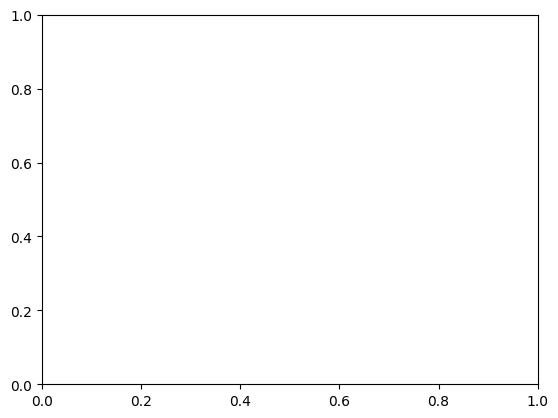

In [143]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_jacc_words = jaccard_df.to_numpy()
########################
# Need to one hot encode this
########################
Y_label = tones.to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X_jacc_words, Y_label, test_size=0.3, random_state=42)

#Test for plotting
X_t = X_train[:, :2]


model_clf = svm.SVC(kernel='linear').fit(X_t, np.ravel(y_train))
#predicted = model_clf.predict(X_test)

fig, ax = plt.subplots()
#title of SVM
title = ('Decision surface of Linear SVC')
# Set-up grid for plotting
X0, X1 = X_train[:,0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, model_clf, xx, yy, cmap = plt.cm.coolwarm, alpha = 0.8)
## here is my issue, need to one-hot encode
ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

#print(accuracy_score(y_test, predicted))